In [1]:
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.optimize import bisect

# Model

The model is
$$
\max_{m_i} \frac{((1-\tau)y_i-\mu pm_i)^{1-\sigma}}{1-\sigma} + \phi (1-\exp(-\alpha_1 - \alpha_0 m_i))
$$
The FOC is 
$$
\mu p ((1-\tau)y_i- \mu pm_i)^{-\sigma} = \phi\alpha_0 \exp(-\alpha_1 - \alpha_0 m_i)
$$
This gives a solution $m_i = {\cal M}(y_i,p|\sigma, \phi, \alpha_0, \alpha_1, \mu)$

Health insurance system
$$
\tau \sum_i \omega_i y_i = (1-\mu)p \sum_i \omega_i m_i~~~\Rightarrow~~~\tau = (1-\mu)s
$$
where $s=pm/y$ with $m=\sum_i \omega_i m_i$ and $y=\sum_i \omega_i y_i$


### US
For the US, we have $p=1$ and $\sum_i \omega_i y_i \equiv y = 1$. Therefore, the moments restrictions  
$$
\Psi_1 = \frac{p \sum_i \omega_i m_i}{\sum_i \omega_i y_i} = \sum_i \omega_i m_i
$$
$$
\Psi_2 = \sum_i \omega_i (1-\exp(-\alpha_1 - \alpha_0 m_i))
$$
$$
\Psi_3 = \frac{(1-\exp(-\alpha_1 - \alpha_0 m_{\max}))}{(1-\exp(-\alpha_1 - \alpha_0 m_{\min}))}
$$
allows to identify $\{\phi,\alpha_0,\alpha_1\}$ with $\tau = (1-\mu) \Psi_1$


### Europe

For Europe, we keep $\{\phi,\alpha_0,\alpha_1\}$ found in the previous step, and the moments restrictions
$$
\Psi_1 = \frac{p \sum_i \omega_i m_i}{\sum_i \omega_i y_i}
$$
$$
\Psi_2 = \sum_i \omega_i (1-\exp(-\alpha_1 - \alpha_0 m_i))
$$
allows to identify $\{p,\alpha_1\}$, given that a calibration of $\sum_i \omega_i y_i \equiv y$ and $\tau = (1-\mu) \Psi_1$



We start by programming functions for finding optimal $m$ from the first-order condition:

In [2]:
def foc(m,sigma_c,phi,alphas,y,p,mu,mom):
	return mu*p*( (1-(1-mu)*mom)*y - mu*p*m )**(-sigma_c) - alphas[0]*phi*np.exp(-alphas[1]-alphas[0]*m)

def u(m,sigma_c,phi,alphas,y,p,mu,mom):
	return ( ((1-(1-mu)*mom)*y - mu*p*m)**(1-sigma_c) )/(1-sigma_c) + phi*(1-np.exp(-alphas[1] - alphas[0]*m))

def optm(sigma_c,phi,alphas,y,p,mu,mom):
	try:
		m = bisect(foc,0.0,y*0.99,args=(sigma_c,phi,alphas,y,p,mu,mom))
	except:
		up  = u(0.99*y,sigma_c,phi,alphas,y,p,mu,mom)
		low = u(0.0,sigma_c,phi,alphas,y,p,mu,mom)
		if up > low:
			m = 0.99*y
		else :
			m = 0.0
	return m

def prod(alphas,m):
	return 1 - np.exp(-alphas[1] - alphas[0]*m)

def hopt(sigma_c,phi,alphas,y,p):
	m = optm(sigma_c,phi,alphas,y,p,mu,mom)
	return prod(alphas,m)

These are the parameters that we end up getting, but we check here that the function works. 

In [3]:
sigma_c   = 2
p_us      = 1

We load up the parameters of the income process and use that to compute 4 median incomes within quartiles. The stationary variance of the income process of each country is 

In [4]:
sigs = [0.256367, 0.094643, 0.214538, 0.237439, 0.169834, 0.094643, 0.270357, 0.486429]

For Europe, we take a mean. 

In [5]:
sig_us = sigs[-1]
sig_eu = np.mean(sigs[0:7])
sig_us,sig_eu

(0.486429, 0.19111728571428574)

We program up the income distribution, making sure it has a mean of 1. 

In [6]:
qs    = [0.125,0.375,0.625,0.875]
yy_us = [norm(0,np.sqrt(sig_us)).ppf(q) for q in qs]
yy_us = np.exp(yy_us)
yy_us = yy_us/np.mean(yy_us)
yy_us,np.mean(yy_us)

(array([0.37922262, 0.67735473, 1.05644178, 1.88698087]), 1.0)

We do the same for Europe but scale down everything to have an average income of 0.78

In [7]:
y_eu  = 0.78
qs    = [0.125,0.375,0.625,0.875]
yy_eu = [norm(0,np.sqrt(sig_eu)).ppf(q) for q in qs]
yy_eu = np.exp(yy_eu)
yy_eu = yy_eu/np.mean(yy_eu)
yy_eu = y_eu*yy_eu
yy_eu,np.mean(yy_eu)

(array([0.44109972, 0.63452033, 0.83837729, 1.20600267]), 0.78)

We use the following moments for the U.S. 

In [8]:
s_us    = 0.15
h_us    = 0.89
grad_us = 1.27
mu_us   = 0.136

We use the following moments for Europe (we do not use the gradient but still compare):

In [9]:
s_eu    = 0.096
h_eu    = 0.93
grad_eu = 1.06
mu_eu   = 0.155

In [10]:
no_social_security = False

In [11]:
if no_social_security:
    mu_us = 1
    mu_eu = 1
else:
    mu_us   = 0.136     
    mu_eu   = 0.155

# Calibration

We start the exercise with finding U.S. parameters that fit the moments. We are solving a set of equations for three unknowns, $\alpha_0$, $\alpha_{1,US}$ and $\phi$. We use the methods of moments to minimize the squared distance of moments. 

In [12]:
def criterion_us(theta,sigma_c,alphas,y,p,mu,moms):
	alphas[0] = theta[0]
	alphas[1] = theta[1]
	phi = theta[2]
	ms = [optm(sigma_c,phi,alphas,i,p,mu,moms[0]) for i in y]
	moms_s = np.zeros(3)
	moms_s[0] = p*np.sum(ms)/np.sum(y)
	moms_s[1] = np.mean([prod(alphas,m) for m in ms])
	moms_s[2] = prod(alphas,ms[3])/prod(alphas,ms[0])
	return (moms[0] - moms_s[0])**2 + (moms[1] - moms_s[1])**2 + (moms[2] - moms_s[2])**2

These are the estimates reported in the text:

In [13]:
alphas_us    = np.zeros(2)
opt_us       = minimize(criterion_us,[5.0,1.5,2],args=(sigma_c,[0.0,0.0],yy_us,p_us,mu_us,[s_us,h_us,grad_us]))
alphas_us[0] = opt_us.x[0]
alphas_us[1] = opt_us.x[1]
phi          = opt_us.x[2]
alphas_us,phi

(array([7.32798668, 1.48332093]), 0.40178750546565317)

We can check that we match moments

In [14]:
ms_us = [optm(sigma_c,phi,alphas_us,i,p_us,mu_us,s_us) for i in yy_us]
np.mean(ms_us), np.mean([prod(alphas_us,m) for m in ms_us]), prod(alphas_us,ms_us[3])/prod(alphas_us,ms_us[0])

(0.1500052976990526, 0.8899994948961651, 1.2699962953184238)

In [15]:
hs_us = [prod(alphas_us,m) for m in ms_us]

In Europe, we seek to estimate $p_{EU}$ and $\alpha_{1,EU}$ using $(s_{EU},h_{EU})$ as moments

In [16]:
def criterion_eu(theta,sigma_c,phi,alphas,y,mu,moms):
	alphas[1] = theta[0]
	p = theta[1]
	ms = [optm(sigma_c,phi,alphas,i,p,mu,moms[0]) for i in y]
	moms_s = np.zeros(2)
	moms_s[0] = p*np.mean(ms)/np.mean(y)
	moms_s[1] = np.mean([prod(alphas,m) for m in ms])
	return (moms[0] - moms_s[0])**2 + (moms[1] - moms_s[1])**2

These are the estimates reported in the paper:

In [17]:
alphas_eu    = np.zeros(2)
alphas_eu[0] = alphas_us[0]
opt_eu = minimize(criterion_eu,[2.0,0.8],args=(sigma_c,phi,alphas_eu,yy_eu,mu_eu,[s_eu,h_eu]))
alphas_eu[1] = opt_eu.x[0]
p_eu = opt_eu.x[1]
alphas_eu[1],p_eu

(1.694639417210526, 0.4516301016193928)

We can check that we fit the targeted moments:

In [18]:
ms_eu = [optm(sigma_c,phi,alphas_eu,i,p_eu,mu_eu,s_eu) for i in yy_eu]
p_eu*np.mean(ms_eu)/np.mean(yy_eu), np.mean([prod(alphas_eu,m) for m in ms_eu])

(0.09598256692470354, 0.9299695071617596)

The gradient is lower than in the U.S. but slighly larger than the target (1.06)

In [19]:
prod(alphas_eu,ms_eu[3])/prod(alphas_eu,ms_eu[0])

1.14778887664414

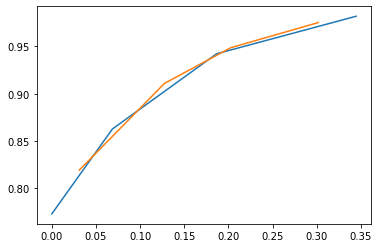

In [20]:
hs_eu = [prod(alphas_us,m) for m in ms_eu]
ms_eu = ms_eu[:]
hs_eu = hs_eu[:]
plt.figure()
plt.plot(ms_us,hs_us)
plt.plot(ms_eu,hs_eu)
plt.show()

## Demand : Price Elasticity in the US

In [21]:
ms0 = [optm(sigma_c,phi,alphas_us,i,p_us,mu_us,s_us) for i in yy_us]
ms1 = [optm(sigma_c,phi,alphas_us,i,p_us*1.01,mu_us,s_us) for i in yy_us]

In [22]:
share0 = p_us*np.mean(ms0)/np.mean(yy_us)
share1 = p_us*1.1*np.mean(ms1)/np.mean(yy_us)
level0 = np.mean(ms0)
level1 = np.mean(ms1)
dxox   = (p_us*1.01-p_us)/p_us

((share1 - share0)/share0)/dxox, ((level1 - level0)/level0)/dxox

(9.248485313346713, -0.6831951696847979)

In [23]:
ms0 = [optm(sigma_c,phi,alphas_us,i,p_us*2,mu_us,s_us) for i in yy_us]
ms1 = [optm(sigma_c,phi,alphas_us,i,p_us*2*1.01,mu_us,s_us) for i in yy_us]

In [24]:
share0 = p_us*2*np.mean(ms0)/np.mean(yy_us)
share1 = p_us*2*1.1*np.mean(ms1)/np.mean(yy_us)
level0 = np.mean(ms0)
level1 = np.mean(ms1)
dxox   = (p_us*2*1.01-p_us*2)/(p_us*2)

((share1 - share0)/share0)/dxox, ((level1 - level0)/level0)/dxox

(9.113514770547221, -0.8058956631388923)

## Demand: Rand Experiment

In [25]:
def focr(m,sigma_c,phi,alphas,y,p,mu,mom,mu0):
	return mu*p*( (1-(1-mu0)*mom)*y - mu*p*m )**(-sigma_c) - alphas[0]*phi*np.exp(-alphas[1]-alphas[0]*m)

def ur(m,sigma_c,phi,alphas,y,p,mu,mom,mu0):
	return ( ((1-(1-mu0)*mom)*y - mu*p*m)**(1-sigma_c) )/(1-sigma_c) + phi*(1-np.exp(-alphas[1] - alphas[0]*m))

def optmr(sigma_c,phi,alphas,y,p,mu,mom,mu0):
	try:
		m = bisect(focr,0.0,y*0.99,args=(sigma_c,phi,alphas,y,p,mu,mom,mu0))
	except:
		up  = ur(0.99*y,sigma_c,phi,alphas,y,p,mu,mom,mu0)
		low = ur(0.0,sigma_c,phi,alphas,y,p,mu,mom,mu0)
		if up > low:
			m = 0.99*y
		else :
			m = 0.0
	return m


In [26]:
ms0 = [optmr(sigma_c,phi,alphas_us,i,p_us,mu_us,s_us,mu_us) for i in yy_us]
ms1 = [optmr(sigma_c,phi,alphas_us,i,p_us,mu_us*1.01,s_us,mu_us) for i in yy_us]

In [27]:
share0 = p_us*np.mean(ms0)/np.mean(yy_us)
share1 = p_us*np.mean(ms1)/np.mean(yy_us)
level0 = np.mean(ms0)
level1 = np.mean(ms1)
dxox   = (mu_us*1.01-mu_us)/mu_us

((share1 - share0)/share0)/dxox, ((level1 - level0)/level0)/dxox

(-0.6831951696847984, -0.6831951696847984)

## Demand : Income Elasticity in the US

In [28]:
ms0 = [optm(sigma_c,phi,alphas_us,i,p_us,mu_us,s_us) for i in yy_us]
ms1 = [optm(sigma_c,phi,alphas_us,i,p_us,mu_us,s_us) for i in yy_us*1.01]

In [29]:
share0 = p_us*np.mean(ms0)/np.mean(yy_us)
share1 = p_us*np.mean(ms1)/np.mean(1.01*yy_us)
level0 = np.mean(ms0)
level1 = np.mean(ms1)
dxox   = (np.mean(1.01*yy_us)-np.mean(yy_us))/np.mean(yy_us)

((share1 - share0)/share0)/dxox, ((level1 - level0)/level0)/dxox

(0.3314988734236481, 1.3348138621578824)

In [30]:
ms0 = [optm(sigma_c,phi,alphas_us,i,p_us,mu_us,s_us) for i in yy_us*2]
ms1 = [optm(sigma_c,phi,alphas_us,i,p_us,mu_us,s_us) for i in yy_us*2*1.01]

In [31]:
share0 = p_us*np.mean(ms0)/np.mean(yy_us*2)
share1 = p_us*np.mean(ms1)/np.mean(1.01*yy_us*2)
level0 = np.mean(ms0)
level1 = np.mean(ms1)
dxox   = (np.mean(1.01*yy_us*2)-np.mean(yy_us*2))/np.mean(yy_us*2)

((share1 - share0)/share0)/dxox, ((level1 - level0)/level0)/dxox

(-0.1428163890074505, 0.8557554471024833)

## Demand : Price Elasticity in Europe

In [32]:
ms0 = [optm(sigma_c,phi,alphas_eu,i,p_eu,mu_eu,s_eu) for i in yy_eu]
ms1 = [optm(sigma_c,phi,alphas_eu,i,p_eu*1.01,mu_eu,s_eu) for i in yy_eu]

In [33]:
share0 = p_eu*np.mean(ms0)/np.mean(yy_eu)
share1 = p_eu*1.1*np.mean(ms1)/np.mean(yy_eu)
level0 = np.mean(ms0)
level1 = np.mean(ms1)
dxox   = (p_eu*1.01-p_eu)/p_eu

((share1 - share0)/share0)/dxox, ((level1 - level0)/level0)/dxox

(9.100040954070954, -0.8181445872082259)

## Demand : Income Elasticity in Europe

In [34]:
ms0 = [optm(sigma_c,phi,alphas_eu,i,p_eu,mu_eu,s_eu) for i in yy_eu]
ms1 = [optm(sigma_c,phi,alphas_eu,i,p_eu,mu_eu,s_eu) for i in yy_eu*1.01]

In [35]:
share0 = p_eu*np.mean(ms0)/np.mean(yy_eu)
share1 = p_eu*np.mean(ms1)/np.mean(1.01*yy_eu)
level0 = np.mean(ms0)
level1 = np.mean(ms1)
dxox   = (np.mean(1.01*yy_eu)-np.mean(yy_eu))/np.mean(yy_eu)

((share1 - share0)/share0)/dxox, ((level1 - level0)/level0)/dxox

(0.6072273268563415, 1.6132996001248914)